In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:15<00:00, 11029282.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return torch.relu(out)

In [6]:
class ResNeXtBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, cardinality=32):
        super().__init__()
        group_width = planes // cardinality
        self.conv1 = nn.Conv2d(in_planes, group_width*cardinality, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(group_width*cardinality)
        self.conv2 = nn.Conv2d(group_width*cardinality, group_width*cardinality, kernel_size=3, 
                              stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(group_width*cardinality)
        self.conv3 = nn.Conv2d(group_width*cardinality, planes*self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes*self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes*self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes*self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes*self.expansion)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        return torch.relu(out)

In [7]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SEResNetBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SEBlock(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        return torch.relu(out)

In [8]:
class StochasticDepth(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        if not self.training:
            return x
            
        binary_tensor = torch.rand(x.size(0), 1, 1, 1, device=x.device) < self.p
        return x * binary_tensor / self.p

class SDResNetBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, p=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.sd = StochasticDepth(p)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.sd(out)
        out += self.shortcut(x)
        return torch.relu(out)

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, **kwargs):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, **kwargs)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, **kwargs)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, **kwargs)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, **kwargs)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, **kwargs):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, **kwargs))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [11]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(loader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return total_loss/len(loader), 100.*correct/total

def test(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return total_loss/len(loader), 100.*correct/total

In [12]:
models = {
    "Original ResNet": ResNet(BasicBlock, [2, 2, 2, 2]),
    "ResNeXt": ResNet(ResNeXtBlock, [2, 2, 2, 2], cardinality=32),
    "SE-ResNet": ResNet(SEResNetBlock, [2, 2, 2, 2]),
    "Stochastic Depth ResNet": ResNet(SDResNetBlock, [2, 2, 2, 2], p=0.5)
}

results = {name: {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []} 
           for name in models.keys()}

epochs = 50
criterion = nn.CrossEntropyLoss()

for name, model in models.items():
    print(f"\nTraining {name}...")
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)
    
    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        test_loss, test_acc = test(model, test_loader, criterion)
        scheduler.step()
        
        results[name]["train_loss"].append(train_loss)
        results[name]["train_acc"].append(train_acc)
        results[name]["test_loss"].append(test_loss)
        results[name]["test_acc"].append(test_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Test Acc: {test_acc:.2f}%")


Training Original ResNet...


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 11.22it/s]


Epoch 1/50 | Test Acc: 40.86%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.04it/s]


Epoch 2/50 | Test Acc: 48.90%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.17it/s]


Epoch 3/50 | Test Acc: 60.25%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.21it/s]


Epoch 4/50 | Test Acc: 65.51%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.64it/s]


Epoch 5/50 | Test Acc: 72.09%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.31it/s]


Epoch 6/50 | Test Acc: 71.32%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.97it/s]


Epoch 7/50 | Test Acc: 74.71%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.78it/s]


Epoch 8/50 | Test Acc: 75.17%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.40it/s]


Epoch 9/50 | Test Acc: 78.81%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.14it/s]


Epoch 10/50 | Test Acc: 81.54%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.11it/s]


Epoch 11/50 | Test Acc: 80.26%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.07it/s]


Epoch 12/50 | Test Acc: 80.92%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.21it/s]


Epoch 13/50 | Test Acc: 79.91%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.43it/s]


Epoch 14/50 | Test Acc: 79.42%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.61it/s]


Epoch 15/50 | Test Acc: 79.73%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.88it/s]


Epoch 16/50 | Test Acc: 79.84%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.64it/s]


Epoch 17/50 | Test Acc: 80.99%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.47it/s]


Epoch 18/50 | Test Acc: 83.20%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.31it/s]


Epoch 19/50 | Test Acc: 82.67%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.71it/s]


Epoch 20/50 | Test Acc: 82.14%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 21/50 | Test Acc: 82.22%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.54it/s]


Epoch 22/50 | Test Acc: 81.80%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.59it/s]


Epoch 23/50 | Test Acc: 85.11%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.98it/s]


Epoch 24/50 | Test Acc: 83.52%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.14it/s]


Epoch 25/50 | Test Acc: 80.38%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 26/50 | Test Acc: 82.68%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.37it/s]


Epoch 27/50 | Test Acc: 80.37%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.09it/s]


Epoch 28/50 | Test Acc: 80.41%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 34.08it/s]


Epoch 29/50 | Test Acc: 84.64%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.13it/s]


Epoch 30/50 | Test Acc: 83.86%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.35it/s]


Epoch 31/50 | Test Acc: 91.49%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 32/50 | Test Acc: 92.20%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.53it/s]


Epoch 33/50 | Test Acc: 92.07%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.67it/s]


Epoch 34/50 | Test Acc: 92.48%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 21.74it/s]


Epoch 35/50 | Test Acc: 92.88%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.08it/s]


Epoch 36/50 | Test Acc: 92.62%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.14it/s]


Epoch 37/50 | Test Acc: 92.67%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 27.30it/s]


Epoch 38/50 | Test Acc: 92.85%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.19it/s]


Epoch 39/50 | Test Acc: 92.74%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.20it/s]


Epoch 40/50 | Test Acc: 93.03%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.41it/s]


Epoch 41/50 | Test Acc: 93.44%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.88it/s]


Epoch 42/50 | Test Acc: 93.47%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.49it/s]


Epoch 43/50 | Test Acc: 93.56%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.82it/s]


Epoch 44/50 | Test Acc: 93.70%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.93it/s]


Epoch 45/50 | Test Acc: 93.51%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.89it/s]


Epoch 46/50 | Test Acc: 93.59%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.19it/s]


Epoch 47/50 | Test Acc: 93.66%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.22it/s]


Epoch 48/50 | Test Acc: 93.71%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.65it/s]


Epoch 49/50 | Test Acc: 93.73%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.99it/s]


Epoch 50/50 | Test Acc: 93.68%

Training ResNeXt...


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.33it/s]


Epoch 1/50 | Test Acc: 36.13%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.49it/s]


Epoch 2/50 | Test Acc: 47.95%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.81it/s]


Epoch 3/50 | Test Acc: 56.14%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.76it/s]


Epoch 4/50 | Test Acc: 65.14%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.77it/s]


Epoch 5/50 | Test Acc: 69.69%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.26it/s]


Epoch 6/50 | Test Acc: 74.11%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.37it/s]


Epoch 7/50 | Test Acc: 74.69%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.70it/s]


Epoch 8/50 | Test Acc: 72.44%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.30it/s]


Epoch 9/50 | Test Acc: 75.92%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.95it/s]


Epoch 10/50 | Test Acc: 73.90%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 39.32it/s]


Epoch 11/50 | Test Acc: 68.91%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.24it/s]


Epoch 12/50 | Test Acc: 73.95%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.81it/s]


Epoch 13/50 | Test Acc: 76.51%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.05it/s]


Epoch 14/50 | Test Acc: 77.70%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.31it/s]


Epoch 15/50 | Test Acc: 76.39%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.97it/s]


Epoch 16/50 | Test Acc: 76.58%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.53it/s]


Epoch 17/50 | Test Acc: 74.23%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.09it/s]


Epoch 18/50 | Test Acc: 76.84%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.15it/s]


Epoch 19/50 | Test Acc: 79.52%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.08it/s]


Epoch 20/50 | Test Acc: 79.70%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 11.24it/s]


Epoch 21/50 | Test Acc: 80.51%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.43it/s]


Epoch 22/50 | Test Acc: 80.52%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.42it/s]


Epoch 23/50 | Test Acc: 69.62%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.25it/s]


Epoch 24/50 | Test Acc: 79.03%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.32it/s]


Epoch 25/50 | Test Acc: 81.35%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 24.47it/s]


Epoch 26/50 | Test Acc: 77.74%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.69it/s]


Epoch 27/50 | Test Acc: 81.63%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.74it/s]


Epoch 28/50 | Test Acc: 81.87%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 23.44it/s]


Epoch 29/50 | Test Acc: 78.90%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.15it/s]


Epoch 30/50 | Test Acc: 82.12%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.01it/s]


Epoch 31/50 | Test Acc: 90.29%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.61it/s]


Epoch 32/50 | Test Acc: 90.96%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00,  9.96it/s]


Epoch 33/50 | Test Acc: 91.22%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.24it/s]


Epoch 34/50 | Test Acc: 91.21%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.28it/s]


Epoch 35/50 | Test Acc: 91.23%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.46it/s]


Epoch 36/50 | Test Acc: 91.27%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.24it/s]


Epoch 37/50 | Test Acc: 91.34%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 26.07it/s]


Epoch 38/50 | Test Acc: 91.87%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.70it/s]


Epoch 39/50 | Test Acc: 91.36%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.93it/s]


Epoch 40/50 | Test Acc: 91.92%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.89it/s]


Epoch 41/50 | Test Acc: 92.55%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.32it/s]


Epoch 42/50 | Test Acc: 92.45%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.64it/s]


Epoch 43/50 | Test Acc: 92.64%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 27.16it/s]


Epoch 44/50 | Test Acc: 92.60%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.82it/s]


Epoch 45/50 | Test Acc: 92.62%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 15.80it/s]


Epoch 46/50 | Test Acc: 92.57%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.42it/s]


Epoch 47/50 | Test Acc: 92.76%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.71it/s]


Epoch 48/50 | Test Acc: 92.63%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.11it/s]


Epoch 49/50 | Test Acc: 92.74%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.32it/s]


Epoch 50/50 | Test Acc: 92.52%

Training SE-ResNet...


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.04it/s]


Epoch 1/50 | Test Acc: 46.64%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.26it/s]


Epoch 2/50 | Test Acc: 63.18%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.78it/s]


Epoch 3/50 | Test Acc: 63.49%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.38it/s]


Epoch 4/50 | Test Acc: 74.54%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.98it/s]


Epoch 5/50 | Test Acc: 65.24%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.34it/s]


Epoch 6/50 | Test Acc: 78.78%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.43it/s]


Epoch 7/50 | Test Acc: 78.27%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 39.85it/s]


Epoch 8/50 | Test Acc: 80.32%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 9/50 | Test Acc: 68.79%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.47it/s]


Epoch 10/50 | Test Acc: 81.52%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.97it/s]


Epoch 11/50 | Test Acc: 79.06%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 38.99it/s]


Epoch 12/50 | Test Acc: 75.50%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.11it/s]


Epoch 13/50 | Test Acc: 81.16%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.19it/s]


Epoch 14/50 | Test Acc: 82.98%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.03it/s]


Epoch 15/50 | Test Acc: 83.13%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 11.32it/s]


Epoch 16/50 | Test Acc: 82.14%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.17it/s]


Epoch 17/50 | Test Acc: 79.48%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.47it/s]


Epoch 18/50 | Test Acc: 77.66%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.14it/s]


Epoch 19/50 | Test Acc: 78.55%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.25it/s]


Epoch 20/50 | Test Acc: 79.32%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.76it/s]


Epoch 21/50 | Test Acc: 84.10%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.48it/s]


Epoch 22/50 | Test Acc: 83.13%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 39.37it/s]


Epoch 23/50 | Test Acc: 84.07%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 39.76it/s]


Epoch 24/50 | Test Acc: 83.79%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  9.36it/s]


Epoch 25/50 | Test Acc: 82.85%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.06it/s]


Epoch 26/50 | Test Acc: 78.03%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.76it/s]


Epoch 27/50 | Test Acc: 78.83%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.83it/s]


Epoch 28/50 | Test Acc: 82.29%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.99it/s]


Epoch 29/50 | Test Acc: 84.51%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.06it/s]


Epoch 30/50 | Test Acc: 79.01%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.55it/s]


Epoch 31/50 | Test Acc: 92.39%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.06it/s]


Epoch 32/50 | Test Acc: 92.86%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.07it/s]


Epoch 33/50 | Test Acc: 92.76%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  9.33it/s]


Epoch 34/50 | Test Acc: 93.17%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.18it/s]


Epoch 35/50 | Test Acc: 93.34%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.28it/s]


Epoch 36/50 | Test Acc: 93.40%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 15.86it/s]


Epoch 37/50 | Test Acc: 93.41%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.11it/s]


Epoch 38/50 | Test Acc: 93.11%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.39it/s]


Epoch 39/50 | Test Acc: 93.35%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.43it/s]


Epoch 40/50 | Test Acc: 93.39%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.47it/s]


Epoch 41/50 | Test Acc: 93.93%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.92it/s]


Epoch 42/50 | Test Acc: 94.08%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.50it/s]


Epoch 43/50 | Test Acc: 94.10%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.70it/s]


Epoch 44/50 | Test Acc: 93.99%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.84it/s]


Epoch 45/50 | Test Acc: 94.23%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 14.05it/s]


Epoch 46/50 | Test Acc: 94.07%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.66it/s]


Epoch 47/50 | Test Acc: 94.08%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.07it/s]


Epoch 48/50 | Test Acc: 94.12%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 15.84it/s]


Epoch 49/50 | Test Acc: 94.17%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.49it/s]


Epoch 50/50 | Test Acc: 94.08%

Training Stochastic Depth ResNet...


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.46it/s]


Epoch 1/50 | Test Acc: 30.12%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.30it/s]


Epoch 2/50 | Test Acc: 39.51%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.50it/s]


Epoch 3/50 | Test Acc: 43.58%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.98it/s]


Epoch 4/50 | Test Acc: 45.67%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.62it/s]


Epoch 5/50 | Test Acc: 53.31%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.46it/s]


Epoch 6/50 | Test Acc: 58.20%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.38it/s]


Epoch 7/50 | Test Acc: 60.59%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.27it/s]


Epoch 8/50 | Test Acc: 63.59%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.48it/s]


Epoch 9/50 | Test Acc: 66.78%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.81it/s]


Epoch 10/50 | Test Acc: 64.04%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.17it/s]


Epoch 11/50 | Test Acc: 69.78%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.60it/s]


Epoch 12/50 | Test Acc: 65.87%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:16<00:00,  4.84it/s]


Epoch 13/50 | Test Acc: 69.93%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.20it/s]


Epoch 14/50 | Test Acc: 71.05%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.47it/s]


Epoch 15/50 | Test Acc: 73.23%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.67it/s]


Epoch 16/50 | Test Acc: 71.16%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.02it/s]


Epoch 17/50 | Test Acc: 75.30%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.94it/s]


Epoch 18/50 | Test Acc: 69.44%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.31it/s]


Epoch 19/50 | Test Acc: 75.84%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.03it/s]


Epoch 20/50 | Test Acc: 74.67%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.81it/s]


Epoch 21/50 | Test Acc: 75.35%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.81it/s]


Epoch 22/50 | Test Acc: 76.58%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.70it/s]


Epoch 23/50 | Test Acc: 76.16%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.27it/s]


Epoch 24/50 | Test Acc: 79.24%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.29it/s]


Epoch 25/50 | Test Acc: 75.66%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.18it/s]


Epoch 26/50 | Test Acc: 76.74%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.73it/s]


Epoch 27/50 | Test Acc: 78.21%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:13<00:00,  5.94it/s]


Epoch 28/50 | Test Acc: 77.45%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.34it/s]


Epoch 29/50 | Test Acc: 78.79%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.74it/s]


Epoch 30/50 | Test Acc: 78.60%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  7.96it/s]


Epoch 31/50 | Test Acc: 84.57%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.29it/s]


Epoch 32/50 | Test Acc: 85.84%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.79it/s]


Epoch 33/50 | Test Acc: 86.06%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  9.65it/s]


Epoch 34/50 | Test Acc: 86.32%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.92it/s]


Epoch 35/50 | Test Acc: 86.87%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.62it/s]


Epoch 36/50 | Test Acc: 86.46%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 11.17it/s]


Epoch 37/50 | Test Acc: 87.00%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.47it/s]


Epoch 38/50 | Test Acc: 87.02%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.66it/s]


Epoch 39/50 | Test Acc: 87.19%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.54it/s]


Epoch 40/50 | Test Acc: 87.45%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.96it/s]


Epoch 41/50 | Test Acc: 88.38%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.15it/s]


Epoch 42/50 | Test Acc: 88.19%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  5.12it/s]


Epoch 43/50 | Test Acc: 88.42%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.00it/s]


Epoch 44/50 | Test Acc: 88.26%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 25.21it/s]


Epoch 45/50 | Test Acc: 88.30%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.41it/s]


Epoch 46/50 | Test Acc: 88.48%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.48it/s]


Epoch 47/50 | Test Acc: 88.48%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.97it/s]


Epoch 48/50 | Test Acc: 88.57%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  4.96it/s]


Epoch 49/50 | Test Acc: 88.61%


Testing: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.86it/s]

Epoch 50/50 | Test Acc: 88.82%


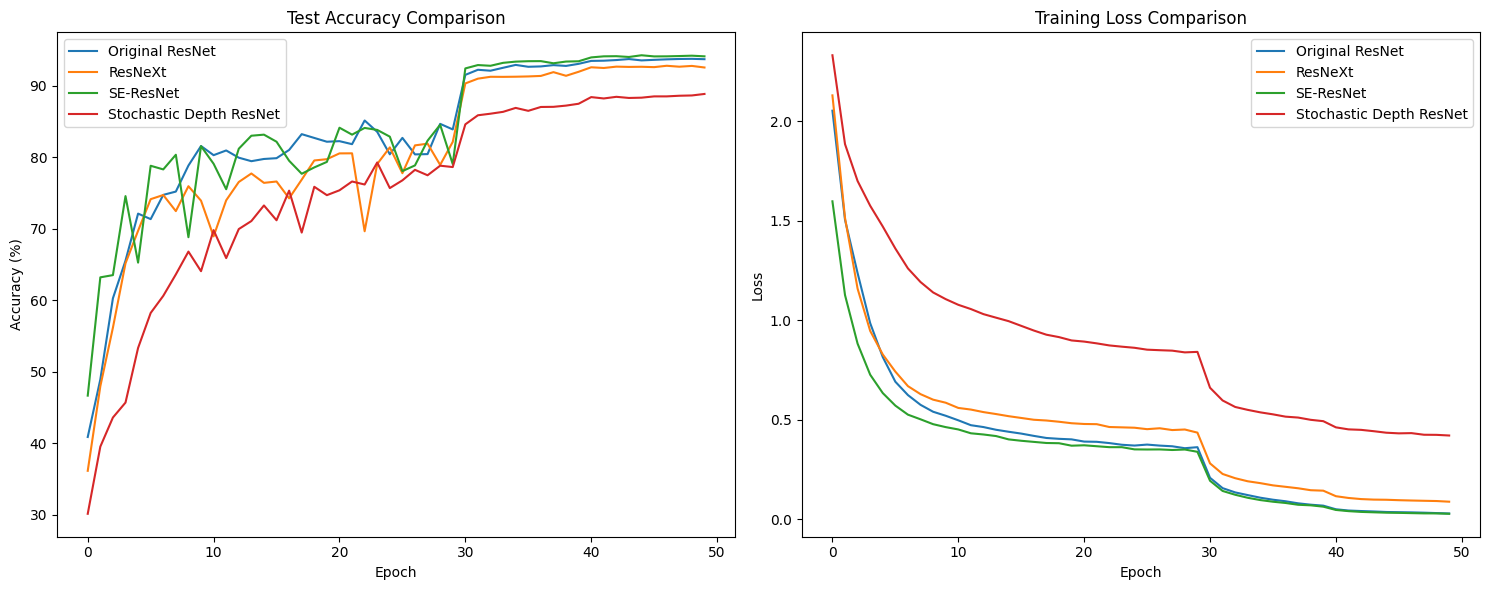


Final Test Accuracy:
Original ResNet: 93.73%
ResNeXt: 92.76%
SE-ResNet: 94.23%
Stochastic Depth ResNet: 88.82%


IOStream.flush timed out


In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for name in models.keys():
    plt.plot(results[name]["test_acc"], label=name)
plt.title("Test Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.subplot(1, 2, 2)
for name in models.keys():
    plt.plot(results[name]["train_loss"], label=name)
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("resnet_variants_comparison.png")
plt.show()

print("\nFinal Test Accuracy:")
for name in models.keys():
    print(f"{name}: {max(results[name]['test_acc']):.2f}%")